In [1]:
import os
import sys

import pandas as pd
import numpy as np

import dask
from dask.distributed import Client
import dask.dataframe as dd

pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 100

## Description of the Data

Data used in this notebook is from the Kaggle Competition "INGV - Volcanic Eruption Prediction"(https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe).

We will explore a bunch of files under `train` and `test` directories. Each file contains ten minutes of logs from ten different sensors arrayed around a volcano. There are 4432 data files under the train directory and 4521 files under test directory. Each of these files consists of 60K lines. On the disk, size of the files under train and test directory is 30G (15G + 15G).

## Challenges with Large Data

As a Data Scientist, we encounter two major challenges when dealing with such a large volume of data:

1. Limited Processing Power: Because of Python's Global Interpreter Lock (GIL), libraries like Pandas or Numpy can use only one processor at any point of time, even when multiple processors available. 

2. Limited Memory: For a workstation, RAM is often limited to 16 or 32 GB. So, it's kind of impossible to load all the data files together. Even the disk space will be limited to around 2 TB.

## Why Dask?
Dask is a framework designed to overcome these limitations:

1. Parallelization using Multiple Cores (avilable in a Single Computer or distributed across multiple computers)
2. Out of Core Computing: If size of the data is larger than the main memory (RAM), dask doesn't load all the data in-memory at a time. It streams the data from the disk as and when needed. If Data doesn't fit into the disk of a single computer, it can be ditributed across multiple computers.

Dask can scale on thousand-machine clusters to handle hundreds of terabytes of data. At the same time, it works efficiently on a single machine as well, enabling analysis of moderately large datasets (100GB+) on relatively low power laptops.

#### How many Processors do I have?

In [2]:
os.cpu_count()

10

This is equal to double the number of CPU Cores since in most of the Computers hyperthreading is enabled.

**Hyperthreading** tells the operating system that it has two cores for every physical core. In my Window's laptop, I have 6 physical cores, but 12 logical processors. But, these 12 logical processors will not give 12x improvement compared to single physical core. Hyperthreading generally gives around 1.25x to 1.3x improvement if two cores give 2x improvement.

## Dask Architechture

<img src="../images/dask_architechture_diagram.png" width="600" height="200" style="border-style: solid;">

#### What is a Client?

The Client connects users to a Dask cluster. After a Dask cluster is setup, we initialize a Client by pointing it to the address of a Scheduler:

```python
from distributed import Client
client = Client("1.2.3.4:8786")
```



#### Start Dask Client

In [3]:
client = Client(n_workers=10)

Here we are creating a Client without specifying the scheduler (cluster) address. In this case, the Client creates a `LocalCluster` in the background and connects to that. Any computation will automatically use this `LocalCluster`.

The above code is effectively same as the following:

```python
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=10)
client = Client(cluster)
```

A client can be closed using:

```python
client.close()
```

By specifying `n_worker=10`, we have asked to dask to start `10` independent python processes. Based on the nature of the cluster, they may run in the same machine or different machines.

### Read the Data

In [4]:
# Point to the directory where all the CSV files are stored
DATA_DIR = "/opt/vssexclude/personal/kaggle/volcano/data/raw/train"

#### How many files are there?

In [5]:
! ls {DATA_DIR} | wc -l

4431


#### Take a quick look of the content of an individual file

In [6]:
! head -3 {DATA_DIR}/2019378960.csv

sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
36.0,1050.0,155.0,643.0,-39.0,843.0,-21.0,96.0,-62.0,-1243.0
8.0,856.0,218.0,705.0,10.0,763.0,-117.0,90.0,-165.0,-1348.0


#### What is the size of one of an individual file

In [7]:
! ls -lh {DATA_DIR}/2019378960.csv

-rw-rw-r-- 1 arnabb arnabb 3.6M Oct  8 23:59 /opt/vssexclude/personal/kaggle/volcano/data/raw/train/2019378960.csv


#### What is the size of all the files together?

In [8]:
! du -h {DATA_DIR}

15G	/opt/vssexclude/personal/kaggle/volcano/data/raw/train


In [9]:
# Define the datatypes for different sensor data
data_types = {"sensor_1" : np.float32, 
                 "sensor_2" : np.float32, 
                 "sensor_3" : np.float32,
                 "sensor_4" : np.float32,
                 "sensor_5" : np.float32,
                 "sensor_6" : np.float32,
                 "sensor_7" : np.float32,
                 "sensor_8" : np.float32,
                 "sensor_9" : np.float32,
                 "sensor_10" : np.float32}

#### Read all the files using Panda

- Need to do it sequentially
- Memory occupied by the objects must be less than the Main Memory (RAM)

```python
%%time
for name in os.listdir(DATA_DIR):
    df = pd.read_csv(f"{DATA_DIR}/{name}", dtype=data_types)
```

```
CPU times: user 2min 30s, sys: 1min 5s, total: 3min 35s
Wall time: 3min 42s
```

#### Read all the files using Dask

In [10]:
%%time
# blocksize is set to value None. A single partition is created for each CSV file
dd_seg = dd.read_csv(
    urlpath=f"{DATA_DIR}/*.csv", 
    blocksize=None, 
    dtype=data_types)

CPU times: user 365 ms, sys: 73.5 ms, total: 439 ms
Wall time: 445 ms


#### What just happened:
- Dask just checked the input path and found that there are multiple CSV files matching the path description
- It has not really read the content of individaul CSV files

In [11]:
print(f"Number of partitions in the Dask DataFrame: {dd_seg.npartitions}")

Number of partitions in the Dask DataFrame: 4431


### How Dask DataFrame is constructed?

<img src="../images/pandas_vs_dask_DF.png" width="600" height="200" style="border-style: solid;">

#### Check the shape of the Dask DataFrame

In [12]:
%%time
# Calculate the number of columns
len(dd_seg.columns)

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 20 µs


10

In [14]:
%%time
# Calculate the number of rows
len(dd_seg)

CPU times: user 13.4 s, sys: 1.34 s, total: 14.8 s
Wall time: 39.1 s


265864431

**There are approximately 265 million rows.**

- Computation of number of columns is fast
- Computation of number of **rows** is slow. 

- How dask is doing this work?

### To make the exploration process faster, we will select only a subset of files and create a Dask DataFrame out of it.

In [15]:
%%time
dd_sample_small = dd.read_csv(
    urlpath=f"{DATA_DIR}/1403*.csv", 
    blocksize=None, 
    dtype=data_types)

CPU times: user 95.6 ms, sys: 22.2 ms, total: 118 ms
Wall time: 119 ms


In [16]:
dd_sample_small

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
npartitions=6,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


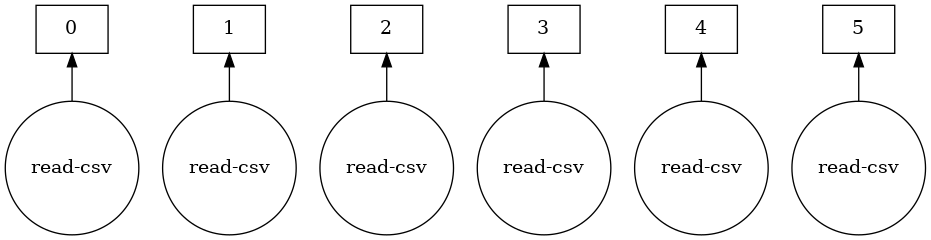

In [17]:
dd_sample_small.visualize()

#### Let's compute the maximum value of the `sensor_1` feature

In [18]:
dd_sample_small.sensor_1.max()

dd.Scalar<series-..., dtype=float32>

Dask has not actually **executed** the code yet. It's lazy. Computation is done only when explicitly asked.

In [19]:
dd_sample_small.sensor_1.max().compute()

5194.0

#### What just happened?
- Dask checked the input path. Identified the matching files
- A bunch of jobs were created. Here, one job per chunk/partition. 
- Each CSV file is loaded into a Pandas Dataframe
- For each Pandas DataFrame, maximum value of `sensor_1` feature is computed
- Results from multiple Pandas DataFrame are combined to get the final result, i.e., the maximum value of `sensor_1` across all the CSVs


#### Notes on `compute()`:
- The result of `compute()` must fit in-memory.



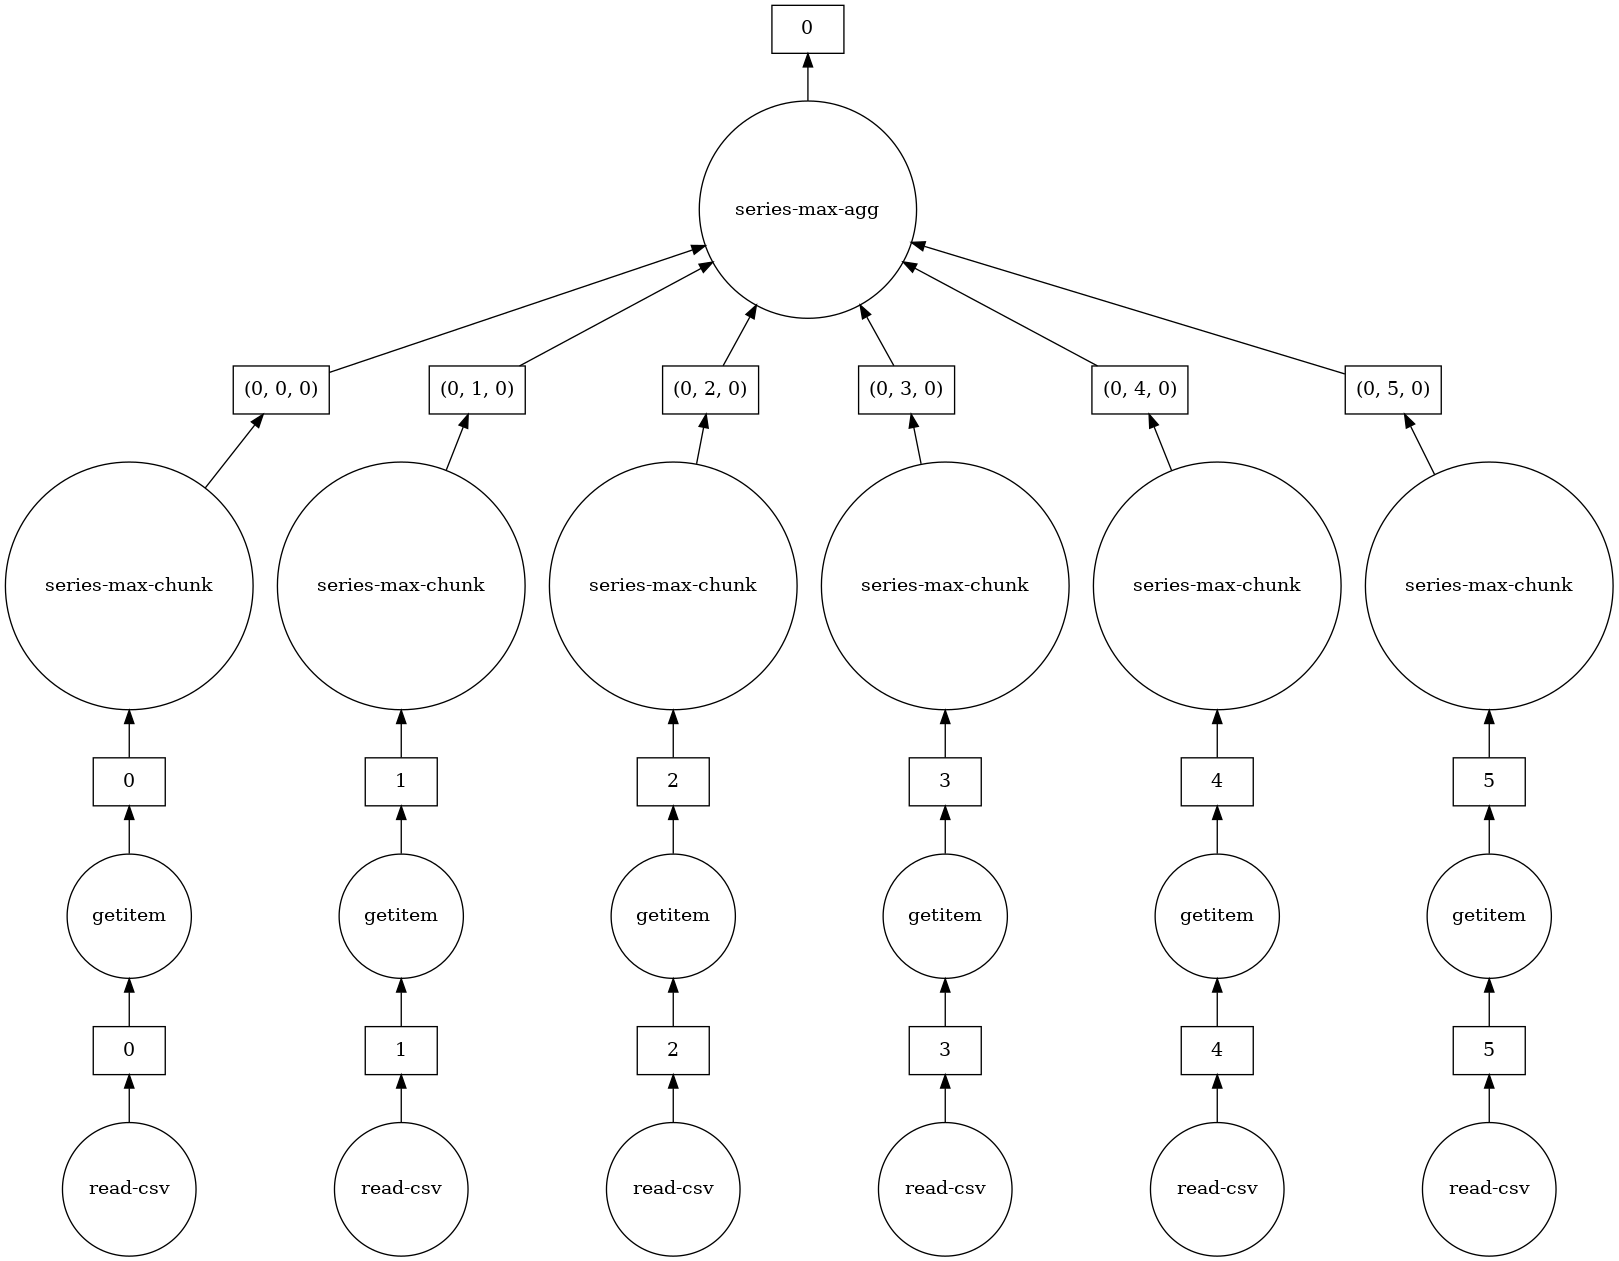

In [20]:
dd_sample_small.sensor_1.max().visualize()

#### Repeat it for a larger Data

In [21]:
%%time 
dd_seg.sensor_1.max().compute()

CPU times: user 14 s, sys: 1.33 s, total: 15.3 s
Wall time: 39.4 s


32767.0

# Screen shot of the computations???

#### Sharing computation for multiple operations

Dask allows duplicate computations to be shared, and only computed once.

In [22]:
sensor_one_std = dd_sample_small.sensor_1.std()
sensor_one_max = dd_sample_small.sensor_1.max()
sensor_one_mean = dd_sample_small.sensor_1.mean()

dd.compute(sensor_one_std, sensor_one_mean)

(375.07538, 0.45454797975589295)

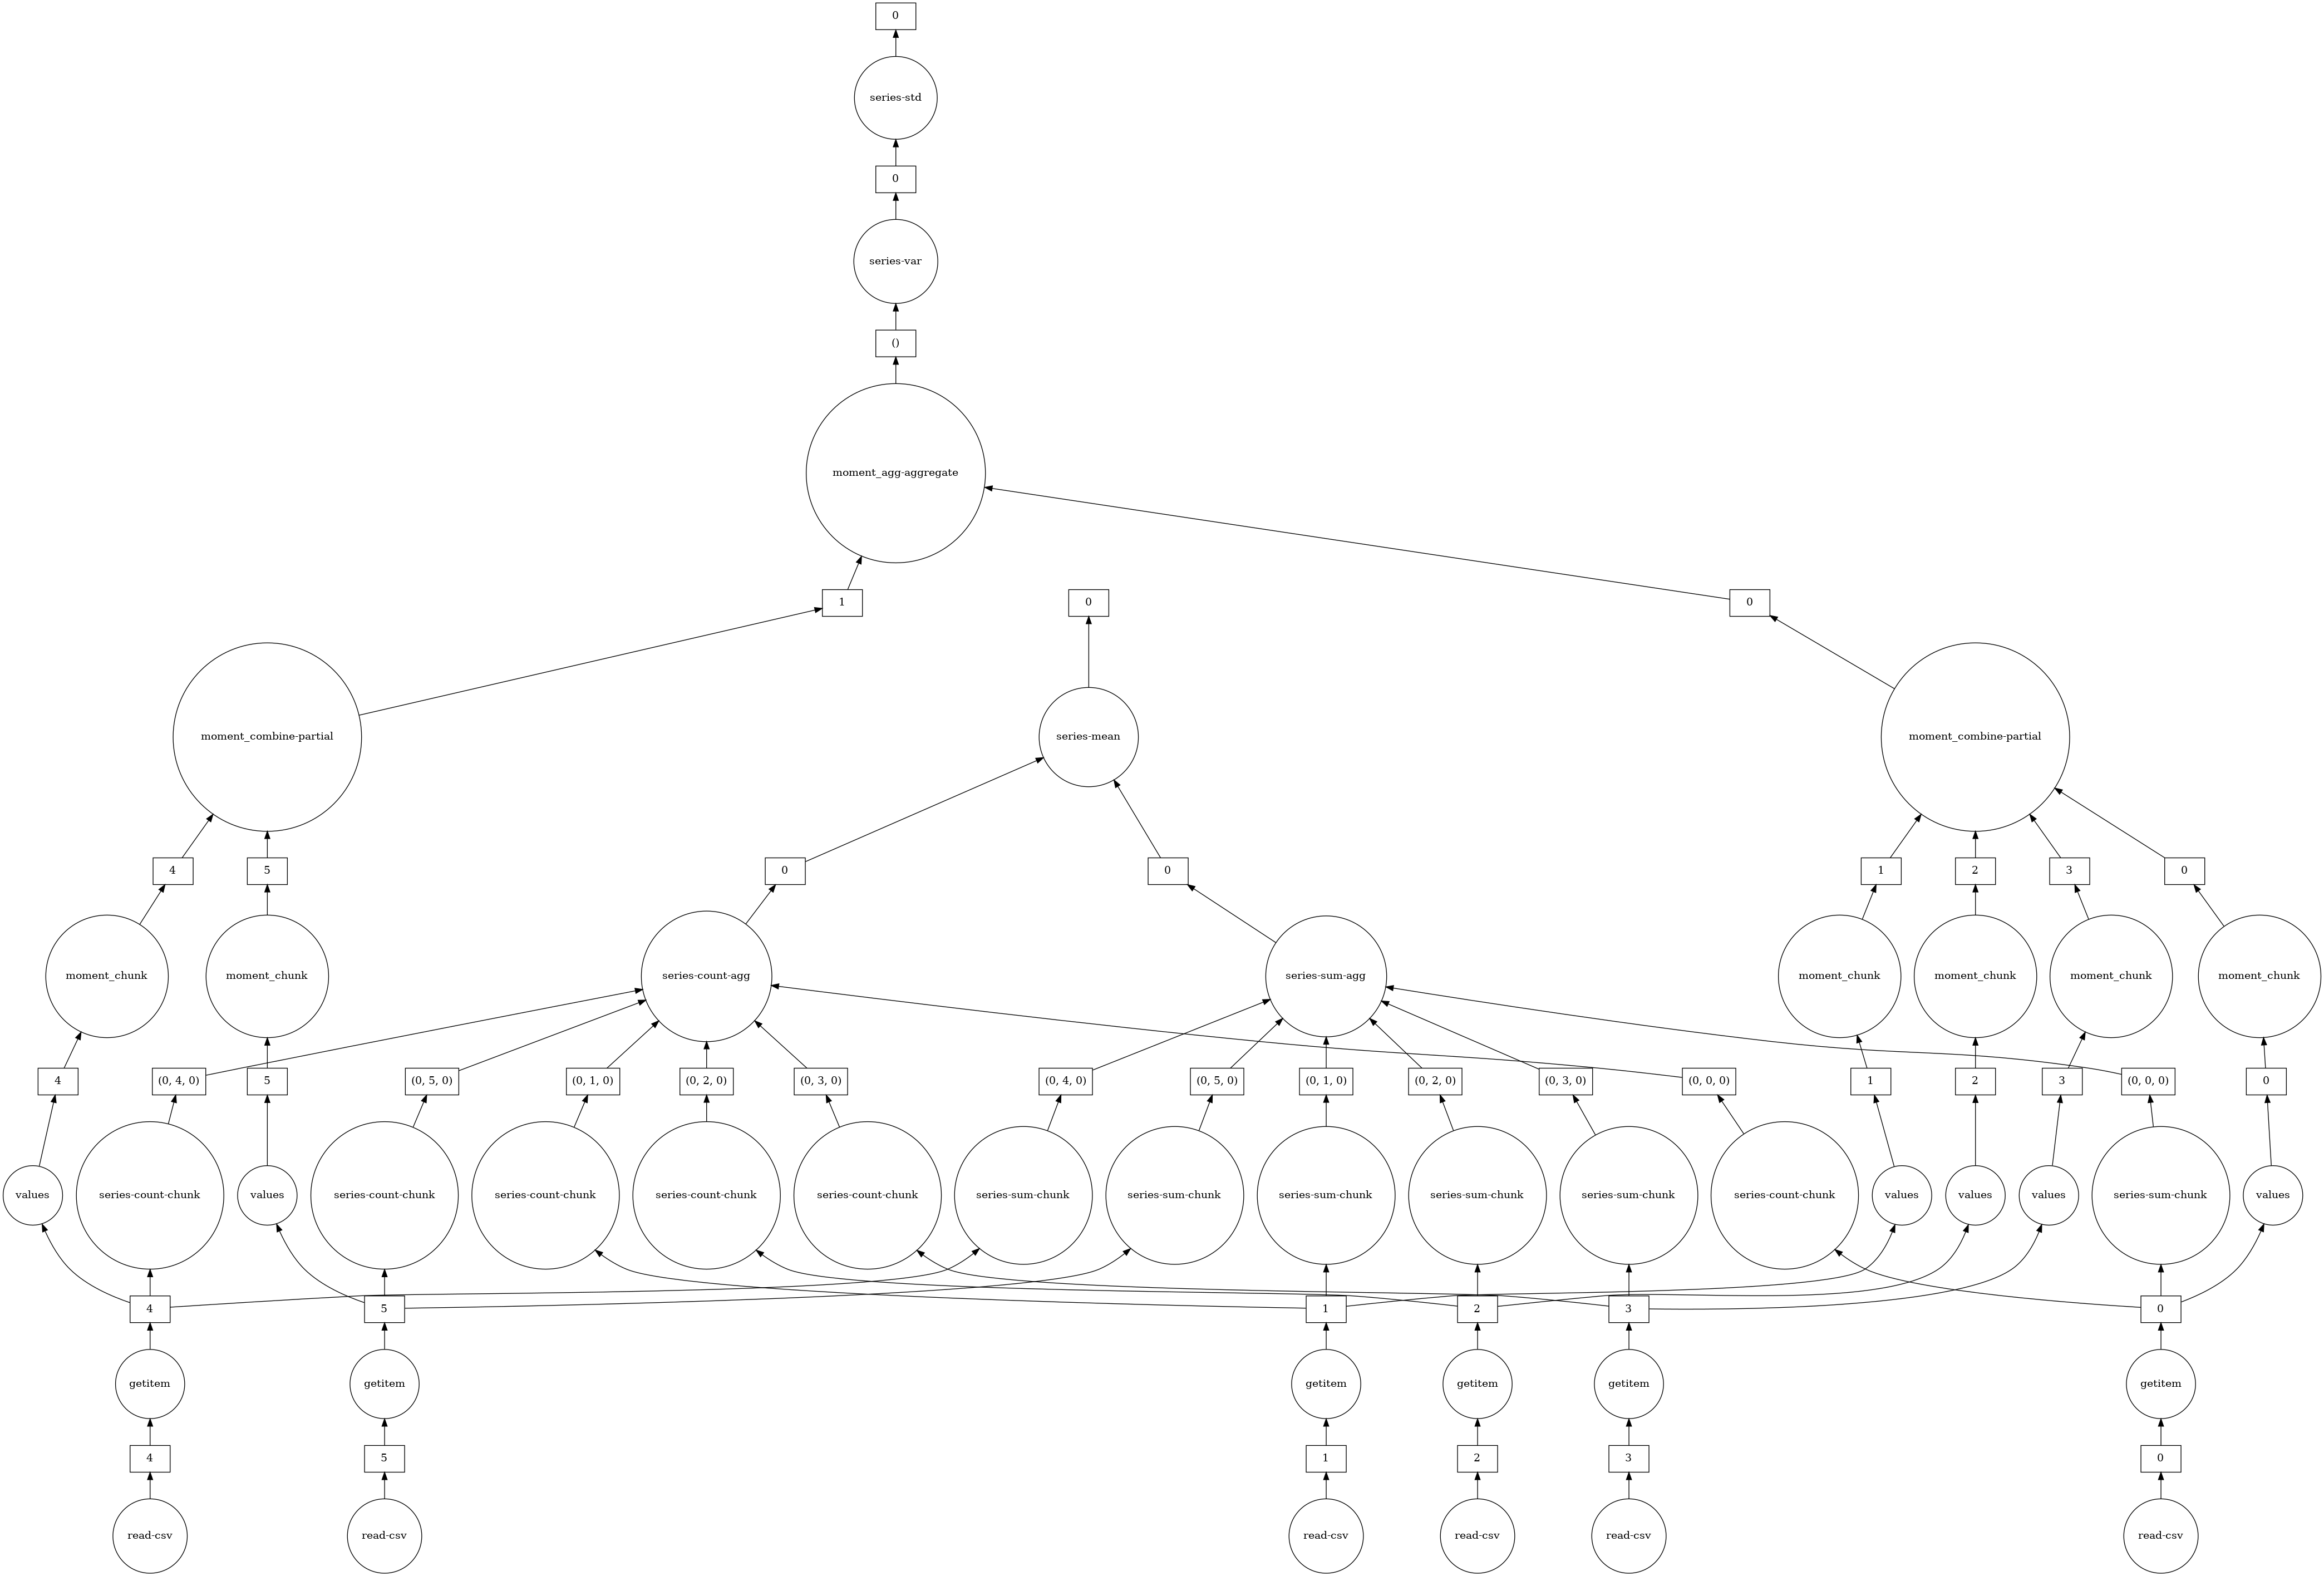

In [23]:
dask.visualize(sensor_one_std, sensor_one_mean)

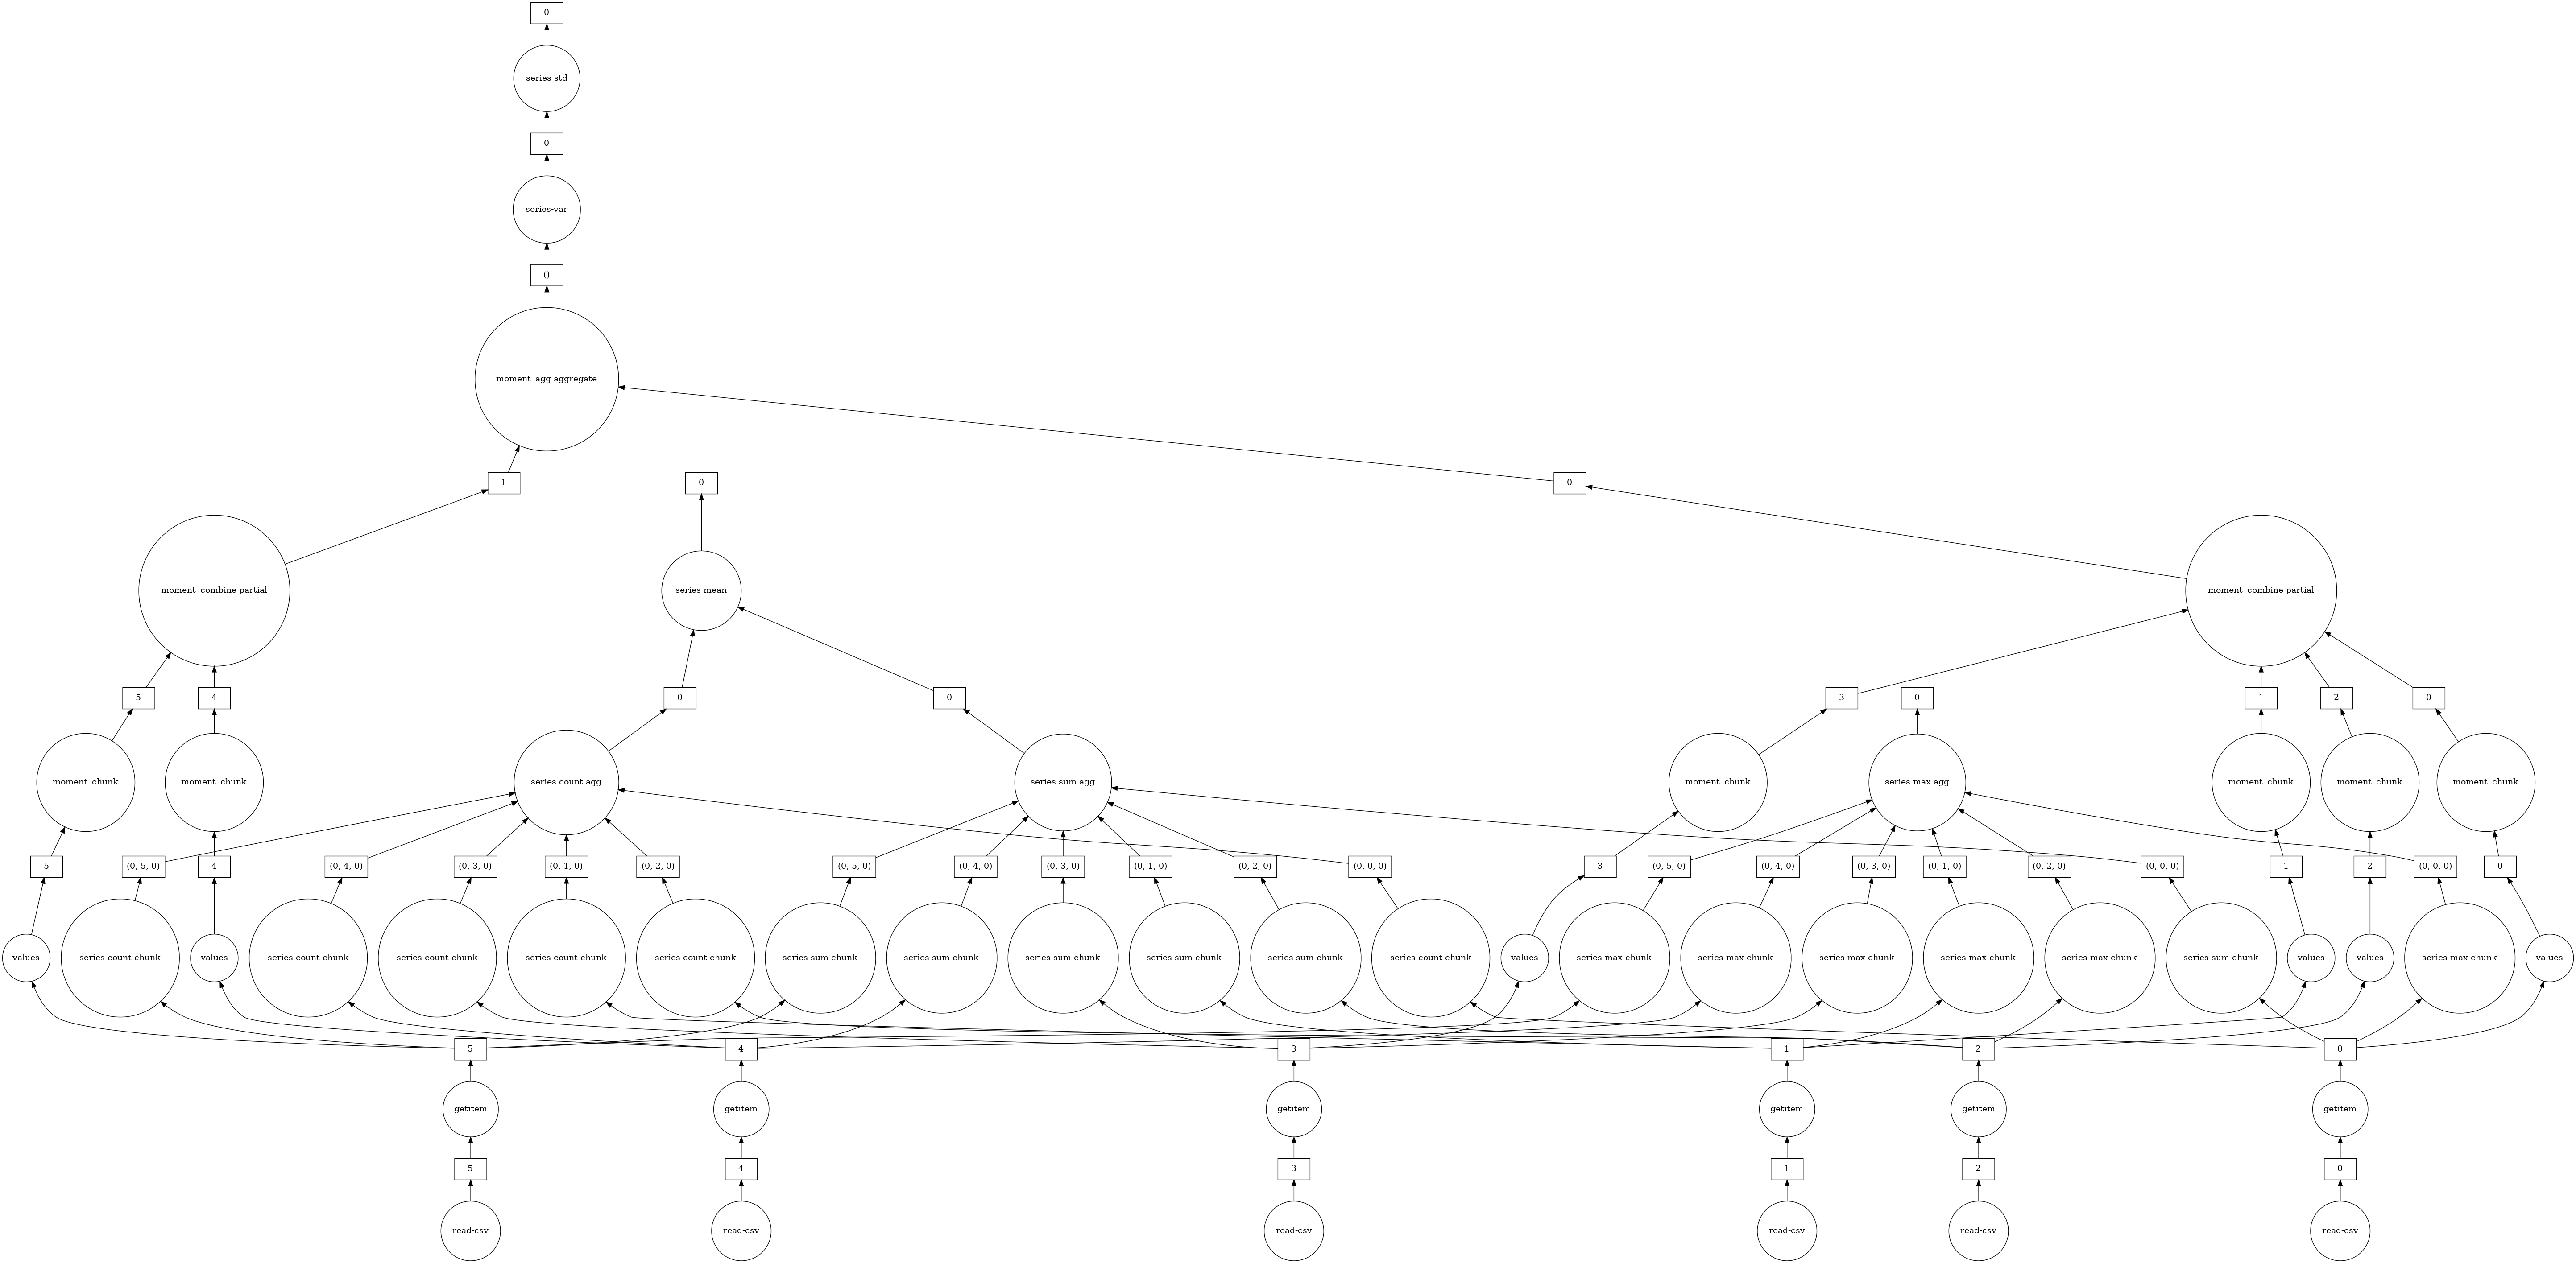

In [24]:
dask.visualize(sensor_one_std, sensor_one_mean, sensor_one_max)

#### Notes about `dask.compute()`
- When calling dask.compute, task graphs for multiple results are merged
- Shared operations are computed only once. 
- `dask.compute()` does the following once:
    - Reading the data for individual partitions (`read_csv` in this case)
    - some of the necessary reductions (sum, count etc.)
    - Common steps if any

### How to execute custom functionality

#### Problem 1

I want to find out the skewness of `sensor_1` for different segments

In [27]:
dd_sample_small.sensor_1.map_partitions(pd.DataFrame.skew).compute()

0   -0.031951
1   -0.024434
2   -0.049013
3   -0.046156
4    0.037749
5    0.102469
dtype: float64

#### Problem 2

Calculate the percentage of missing values across sensors for all the segments

In [28]:
def get_missing_sensors(df):
    """
    Returns a DataFrame consisting percentage of missing data per sensor
    """
    df_missing_percentage = df.isna().mean().to_frame().transpose()
    df_missing_percentage = df_missing_percentage.astype(np.float16)
    return df_missing_percentage

In [29]:
df_train_seg_missing = dd_sample_small.map_partitions(get_missing_sensors).compute()

df_train_seg_missing

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.024902,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


#### Note
 - `map_partitions()` applies any Python function on each DataFrame partition.

In [30]:
client.close()